In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
from scipy.optimize import curve_fit
import h5py
from pathlib import Path
from collections.abc import Iterable

In [2]:
datapath = Path.cwd() / "data"
figurepath = Path.cwd().parent / "figures"

In [3]:
W = 5.88    # Figure width in inches, approximately A4-width - 2*1.25in margin
plt.rcParams.update({
    'figure.figsize': (W, W),#/(4/3)),     # 1:1 aspect ratio
    'font.size' : 11,                   # Set font size to 11pt
    'axes.labelsize': 11,               # -> axis labels
    'legend.fontsize': 10,              # -> legends
    'font.family': 'lmodern',
    'text.usetex': True,
    'text.latex.preamble': (            # LaTeX preamble
        r'\usepackage{lmodern}'
        # ... more packages if needed
    )
})

In [4]:
def set_size(width='thesis', fraction=1, subplots=(1, 1)):
    """Set figure dimensions to avoid scaling in LaTeX.

    Parameters
    ----------
    width: float or string
            Document width in points, or string of predined document type
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy
    subplots: array-like, optional
            The number of rows and columns of subplots.
    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    if width == 'thesis':
        width_pt = 426.79135
    elif width == 'beamer':
        width_pt = 307.28987
    else:
        width_pt = width

    # Width of figure (in pts)
    fig_width_pt = width_pt * fraction
    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3
    aspect_ratio = 1#(5**.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * aspect_ratio * (subplots[0] / subplots[1])

    return (fig_width_in, fig_height_in)


In [5]:
def rearrange_data(arr): #
    res = np.swapaxes(arr,-1,0)
    res = np.swapaxes(res,-2,1)
    return res

def disorder_mean(A, n_samples = None):
    if n_samples is None:
        return np.mean(A,2)
    else:
        return np.mean(A[:,:,0:n_samples],2)

def disorder_std(A, n_samples = None):
    if n_samples is None:
        return np.std(A,2)
    else:
        return np.std(A[:,:,0:n_samples],2)

In [37]:
def idx_transgression(arr,threshold):
    idx = np.zeros(arr.shape[1],dtype=int)
    for j in range(arr.shape[1]):
        found = False
        for i in range(arr.shape[0]):
            if found == False and arr[i,j] >= threshold:
                idx[j] = i
                found = True
        if found == False:
            idx[j] = -1 #be careful that this never breaks things
    return idx

def safeguard_minusone(idx):
    res = np.zeros(idx.shape[0],dtype=float)
    for i in range(idx.shape[0]):
        res[i] = idx[i] if idx[i] != -1 else np.nan
    return res

def mask_transgression(arr,threshold):
    mask = np.zeros(arr.shape,dtype=bool)
    idx = idx_transgression(arr,threshold)
    for j in range(arr.shape[1]):
        if idx[j] != -1:
            mask[idx[j],j]=True
    return mask

def T_transgression(T,arr,threshold):
    idx = idx_transgression(arr,threshold)
    t_past = T[idx]
    t_before = T[[i-1 if i > 0 else 0 for i in idx]]
    arr_past = np.zeros(arr.shape[1])
    arr_before = np.zeros(arr.shape[1])
    t_th = np.zeros(arr.shape[1])
    for j in range(0,arr.shape[1]):
        arr_past[j] = arr[idx[j],j]
        arr_before[j] = arr[idx[j]-1 if idx[j] > 0 else 0,j]

        t_th[j] = (threshold-arr_before[j])/(arr_past[j]-arr_before[j]) * (t_past[j]-t_before[j]) + t_before[j]
    return t_th

def symmetrize(arr):
    N = arr.shape[1]
    symarr = np.zeros((arr.shape[0],N//2+1))
    for j in range(0,N//2):
        symarr[:,j] = 0.5*(arr[:,j]+arr[:,N-j-1])
    symarr[:,N//2] = arr[:,N//2]
    return symarr

In [38]:
jobids = []
params = []
data = []
folder = datapath/"sectors"
files = ["1286{}_N15_ED.jld2".format(i) for i in range(79,89)]+["129519_N15_ED.jld2"]+["1286{}_N15_ED.jld2".format(i) for i in range(90,95)]+["130717_N15_ED.jld2"]
for (i,file) in enumerate(files):
    with h5py.File(folder/file,"r") as f:
            jobids.append(f["jobid"][()].decode("UTF-8"))
            data.append(2-2*rearrange_data(f["data"][()]))
            params.append(f["params"][()])
#for  i in range(1,len(files)):
 #       data[i] = np.concatenate(data[i],axis=2)
#T = np.arange(0,2.01,0.01)

In [39]:
N = 15
T = 10 ** np.linspace(-3,6,100)
xcenter = N//2
x = np.arange(0,N//2+1,1)
rvals = np.array([abs(pos-xcenter) for pos in range(0,N)])
dims = {0:1,
        1:15,
        2:105,
        3:455,
        4:1365,
        5:3003,
        6:5005,
        7:6435,
        8:6435,
        9:5005,
        10:3003,
        11:1365,
        12:455,
        13:105,
        14:15,
        15:1}

In [44]:
res = [data[i][:,:,0] for i in range(N+1)]
res_total = data[-1][:,:,0]
red = list(map(symmetrize,res))
red_total = symmetrize(res_total)

In [46]:
for k in range(N):
    print("k={}, d={}: {:.2f}\n".format(k,dims[k],np.mean(red[k][66:])))

k=0, d=1: 0.00

k=1, d=15: 0.14

k=2, d=105: 0.43

k=3, d=455: 0.82

k=4, d=1365: 1.22

k=5, d=3003: 1.58

k=6, d=5005: 1.84

k=7, d=6435: 1.98

k=8, d=6435: 1.98

k=9, d=5005: 1.84

k=10, d=3003: 1.58

k=11, d=1365: 1.22

k=12, d=455: 0.82

k=13, d=105: 0.43

k=14, d=15: 0.13



In [47]:
mean = 0
for k in range(N):
    mean += np.mean(red[k][66:])*dims[k]
mean = mean/2**N
mean

1.7590174733625457

In [52]:
err = 0
for k in range(N):
    err += (np.std(red[k][66:],ddof=1)*dims[k]/np.sqrt(34*8))**2
err = np.sqrt(err)/2**N
err

0.0001520524312424624

In [51]:
np.mean(red_total[66:])
np.std(red_total[66:],ddof=1)/np.sqrt(34*8)

0.005679806687327357

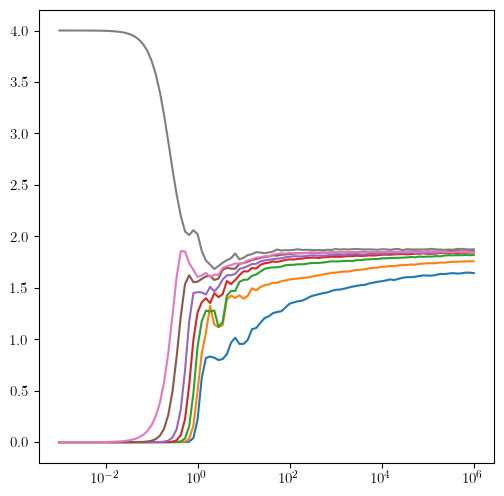

In [64]:
plt.semilogx(T[:],red_total[:])